<a href="https://colab.research.google.com/github/boopathiraja14/timeseries/blob/main/milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone project - combed dataset analysis

#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime
import matplotlib.dates as dates
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

pd.set_option('display.float_format', str)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Collect all csv's from folders

In [ ]:
def scan_folder(parent, col):
  # df = pd.DataFrame()
  for file_name in os.listdir(parent):
    remove = ['', 'content', 'drive', 'MyDrive', 'combed', 'iiitd']
    names = parent.split('/')
    temp = [i for i in names if i not in remove]
    if file_name.endswith(".csv"):
      df = pd.read_csv("".join((parent, "/", file_name)), names=['time_stamp', 'value'])
      df['block'] = temp[0]
      df['building'] = temp[1]
      df['floor'] = temp[2]
      df['reading'] = file_name.replace('.csv', '')
      # print(df.head(1))
      # break
      col.append(df)
    else:
      current_path = "".join((parent, "/", file_name))
      if os.path.isdir(current_path):
        scan_folder(current_path, col)
  return col


In [ ]:
col = []
cols = scan_folder('/content/drive/MyDrive/combed/iiitd', col)  


# Transform

In [ ]:
df = pd.concat(cols)
df['date'] = df['time_stamp'].apply(lambda x:datetime.fromtimestamp(float(x)/1000))
df = df.drop(columns=['time_stamp'])
df = df[['date','block','building','floor','reading','value']]
# df = df.set_index('date', drop=True)
df = df.groupby([pd.Grouper(key='date', freq='H'), 'block', 'building', 'reading']).agg({'value':'sum'}).reset_index()

In [ ]:
df.shape

(29592, 5)

In [ ]:
df.head()

,date,block,building,reading,value
0,2014-06-01 04:00:00,Academic Block,AHU,Current,123.05878412723541
1,2014-06-01 04:00:00,Academic Block,AHU,Energy,1946085659.25
2,2014-06-01 04:00:00,Academic Block,AHU,Power,88.13784790039062
3,2014-06-01 04:00:00,Academic Block,Floor Total,Current,1297.483805179596
4,2014-06-01 04:00:00,Academic Block,Floor Total,Energy,11515133931.0


In [ ]:
df = df.pivot(index=['date', 'block', 'building'], columns='reading', values='value').reset_index()

In [ ]:
df = df.set_index('date', drop=True)

In [ ]:
df.head()

reading,block,building,Current,Energy,Power
date,,,,,
2014-06-01 04:00:00,Academic Block,AHU,123.05878412723541,1946085659.25,88.13784790039062
2014-06-01 04:00:00,Academic Block,Floor Total,1297.483805179596,11515133931.0,855613.0790405273
2014-06-01 04:00:00,Academic Block,Light,175.95382165908813,54312299.0625,116064.54248046875
2014-06-01 04:00:00,Academic Block,Power,25.773179531097412,244866733.75,6483.336795806885
2014-06-01 04:00:00,Academic Block,Power Sockets,25.773179531097412,244866733.75,6483.336795806885


In [ ]:
ac_df = df[df['block'] == 'Academic Block'].copy()
lc_df = df[df['block'] == 'Lecture Block'].copy()

In [ ]:
ac_df.shape, lc_df.shape

((5706, 5), (4158, 5))

# Visualize the academic block Energy consumption trends

Text(0.5, 1.0, 'Power vs Energy')

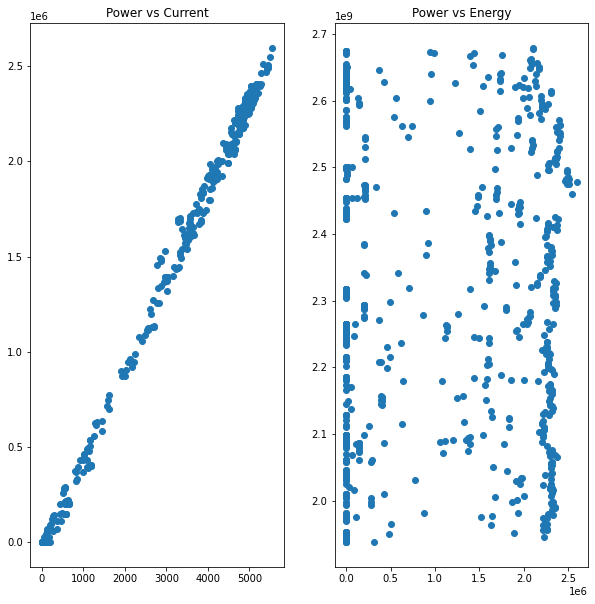

In [ ]:
temp = ac_df[ac_df['building'] == 'AHU']
# temp = temp.loc['2014-06-01' : '2014-06-20']
fig, ax = plt.subplots(1,2, figsize=(10,10))
# ax.scatter(temp.index, temp.Power)
ax[0].scatter(temp['Current'] ,temp['Power'],)
ax[0].set_title('Power vs Current')
ax[1].scatter(temp['Power'] ,temp['Energy'],)
ax[1].set_title('Power vs Energy')

# ax.plot(temp.index, temp['Current'],)


#Academic Block

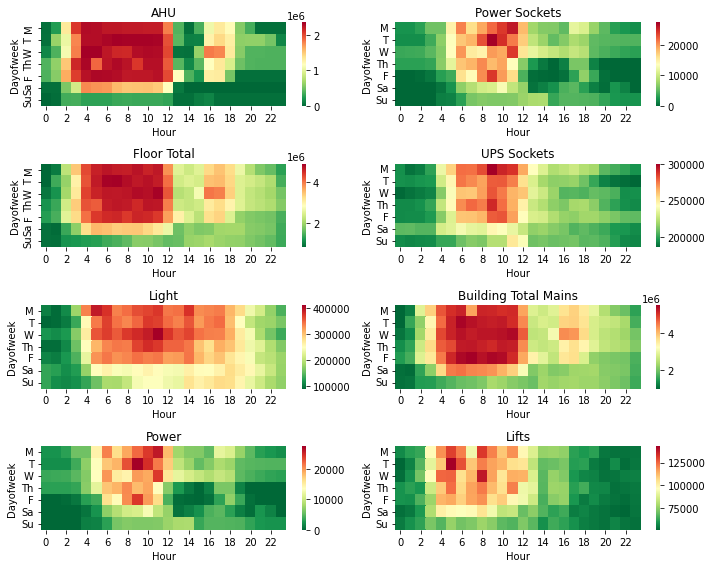

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(10,8))
ax = [leaf[0]  for leaf in (tree for tree in axes)] + [leaf[1]  for leaf in (tree for tree in axes)] 

for i, build in enumerate(ac_df['building'].unique()):

  temp = ac_df.loc[ac_df['building'] == build].copy()

  temp['Dayofweek'] = temp.index.weekday
  temp['Dayofweek'] = temp['Dayofweek'].map({0:'M', 1:'T', 2:'W', 3:'Th', 4:'F', 5:'Sa', 6:'Su'})
  temp['Hour'] = temp.index.hour
  temp['Dayofweek'] = pd.Categorical(temp['Dayofweek'], ['M','T','W','Th','F','Sa','Su'])

  temp = temp[['Hour', 'Dayofweek', 'Power']].groupby(['Hour', 'Dayofweek']).agg({'Power':'mean'}).reset_index()
  temp = temp.pivot('Dayofweek', 'Hour', 'Power').sort_index()

  sns.heatmap(temp, cmap='RdYlGn_r', ax=ax[i])
  ax[i].set_title(build)

  plt.tight_layout()




# Lecture block

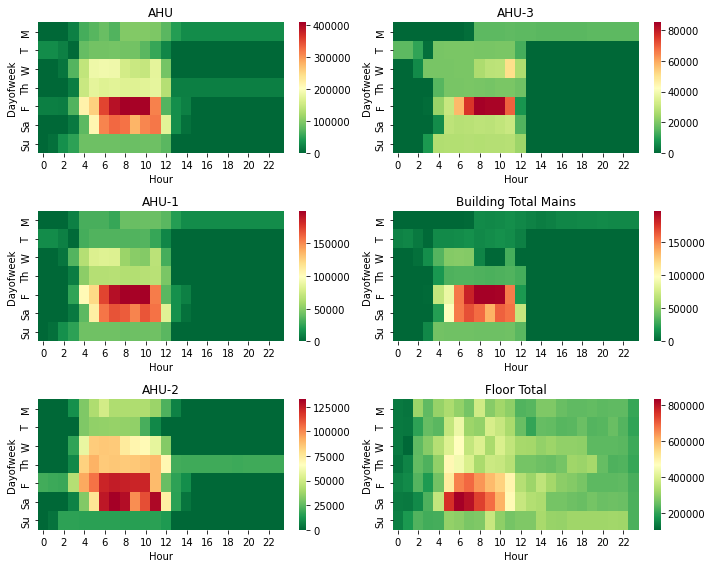

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(10,8))
ax = [leaf[0]  for leaf in (tree for tree in axes)] + [leaf[1]  for leaf in (tree for tree in axes)] 

for i, build in enumerate(lc_df['building'].unique()):

  temp = lc_df.loc[lc_df['building'] == build].copy()

  temp['Dayofweek'] = temp.index.weekday
  temp['Dayofweek'] = temp['Dayofweek'].map({0:'M', 1:'T', 2:'W', 3:'Th', 4:'F', 5:'Sa', 6:'Su'})
  temp['Hour'] = temp.index.hour
  temp['Dayofweek'] = pd.Categorical(temp['Dayofweek'], ['M','T','W','Th','F','Sa','Su'])

  temp = temp[['Hour', 'Dayofweek', 'Power']].groupby(['Hour', 'Dayofweek']).agg({'Power':'mean'}).reset_index()
  temp = temp.pivot('Dayofweek', 'Hour', 'Power').sort_index()

  sns.heatmap(temp, cmap='RdYlGn_r', ax=ax[i])
  ax[i].set_title(build)

  plt.tight_layout()


# Top/Bottom consumers

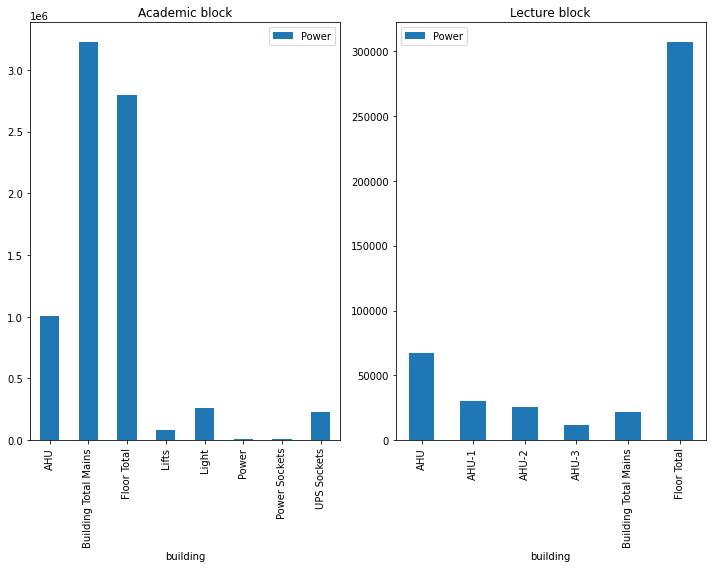

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ac_df.groupby(['building']).agg({'Power':'mean'}).plot.bar(ax=ax1)
lc_df.groupby(['building']).agg({'Power':'mean'}).plot.bar(ax=ax2)
ax1.set_title('Academic block')
ax2.set_title('Lecture block')
plt.tight_layout()

# Forecasting 

In [ ]:
base_df = ac_df.loc[ac_df['building'] == 'Building Total Mains', 'Power'].copy()

In [ ]:
base_df = pd.DataFrame(base_df)

In [ ]:
base_df.head()

,Power
date,
2014-06-02 07:00:00,333575.43359375
2014-06-02 08:00:00,5069983.2421875
2014-06-02 09:00:00,4943217.11328125
2014-06-02 10:00:00,4753335.41015625
2014-06-02 11:00:00,4874460.9453125


# There are hourly and weekly patterns present

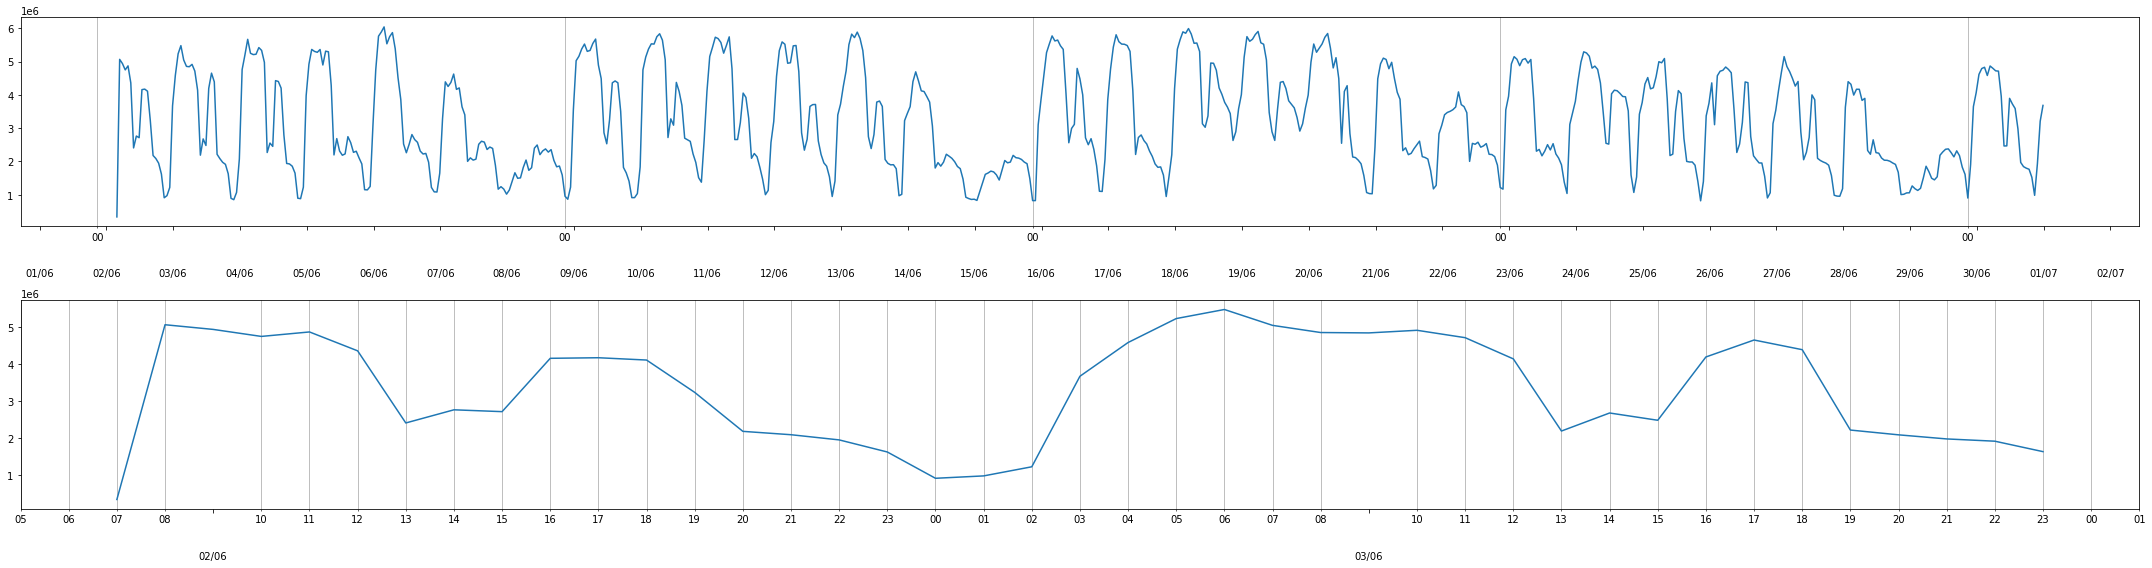

In [ ]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(30,8))

ax1.plot(base_df)
ax1.xaxis.set_minor_locator(dates. WeekdayLocator(byweekday=0, interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
rule = dates.rrulewrapper(dates.DAILY)
loc = dates.RRuleLocator(rule)
ax1.xaxis.set_major_locator(loc)
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%d/%m'))
ax1.xaxis.grid(True, which='minor')


ax2.plot(base_df['2014-06-02':'2014-06-03'])
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
rule = dates.rrulewrapper(dates.DAILY)
loc = dates.RRuleLocator(rule)
ax2.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%d/%m'))
ax2.xaxis.grid(True, which='minor')
plt.tight_layout()


# Check for stationarity 

P value is less,but still higher then strict cutoff 0.01 , let us first order difference and check

In [ ]:
data = base_df['Power'].values
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.993733
p-value: 0.035484
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [ ]:
# First order diff gave zero P value, so sticking with 1

In [ ]:
data_diff =  base_df['Power'].diff(1)
result = adfuller(data_diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.438738
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Text(0, 0.5, 'Residual')

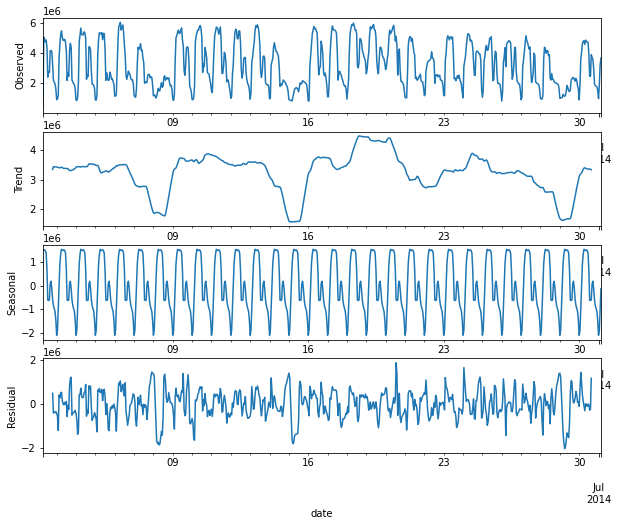

In [ ]:
decomposition = sm.tsa.seasonal_decompose(base_df['Power'], model='additive', freq=24)

fig, axes = plt.subplots(4, 1, figsize=(10,8))
decomposition.observed.plot(ax=axes[0] )
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1],  )
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2],)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], )
axes[3].set_ylabel('Residual')

# Both seasonal and total series have similar ACF and PACF

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


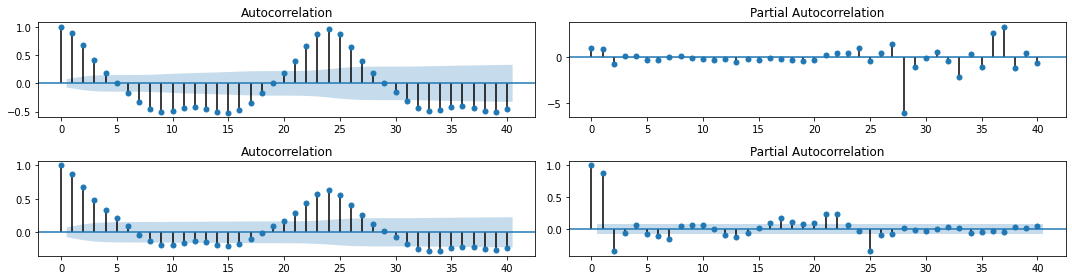

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(decomposition.seasonal, lags=40, ax=axes[0,0])
fig = sm.graphics.tsa.plot_pacf(decomposition.seasonal, lags=40, ax=axes[0,1])
fig = sm.graphics.tsa.plot_acf(base_df, lags=40, ax=axes[1,0])
fig = sm.graphics.tsa.plot_pacf(base_df, lags=40, ax=axes[1,1])
plt.tight_layout()

In [ ]:
train = base_df[:'2014-06-22']
test = base_df['2014-06-23':]

# P D Q - selection rationale 

from PACF plots, we can see correlation drop drstically after 3 lags so P = 3
from our stantionarity ADF tests, we choose to go with first order difference , so D = 1
from ACF plot we see significant values of 4 lags , but adding MA part gives marginal improvement, so to speed up calculation process sticking with AR part alone, so Q = 0



In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(3, 1, 0),
                                seasonal_order=(3, 1, 0, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.aic, '\n', results.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11623.3976452257 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0690      0.056      1.241      0.215      -0.040       0.178
ar.L2         -0.1729      0.064     -2.696      0.007      -0.299      -0.047
ar.L3         -0.0694      0.068     -1.024      0.306      -0.202       0.063
ar.S.L24      -0.5799      0.050    -11.658      0.000      -0.677      -0.482
ar.S.L48      -0.3839      0.052     -7.407      0.000      -0.485      -0.282
ar.S.L72      -0.1167      0.054     -2.179      0.029      -0.222      -0.012
sigma2      3.819e+11   2.17e-14   1.76e+25      0.000    3.82e+11    3.82e+11


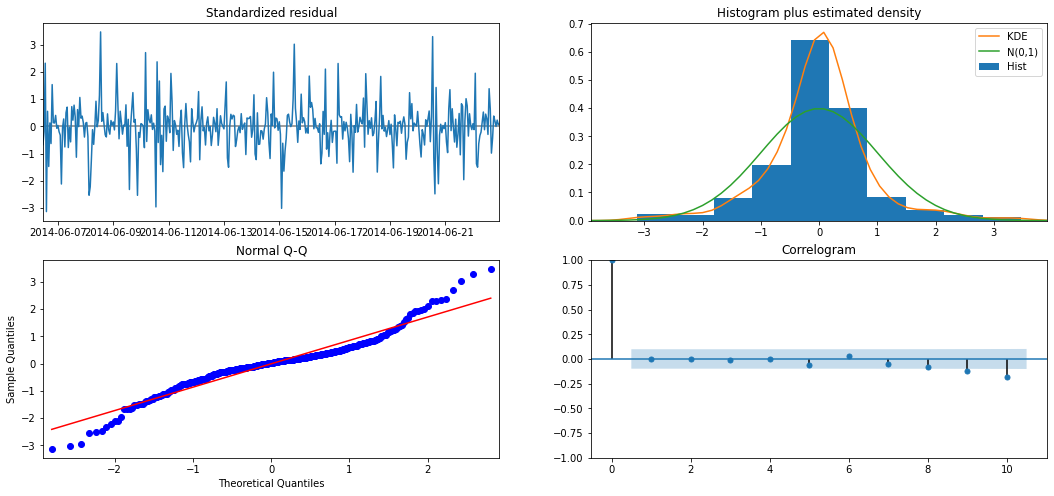

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2014-06-23'), end=pd.to_datetime('2014-06-30'), dynamic=False)

In [ ]:
prediction = pred.predicted_mean

# Holt - winter method 

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
model = HWES(train, seasonal_periods=24, trend='add', seasonal='add')
fitted = model.fit(optimized=True, use_brute=True)
print(fitted.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   497
Model:             ExponentialSmoothing   SSE                 218499270328791.750
Optimized:                         True   AIC                           13380.179
Trend:                         Additive   BIC                           13498.020
Seasonal:                      Additive   AICC                          13384.171
Seasonal Periods:                    24   Date:                  Fri, 05 Nov 2021
Box-Cox:                          False   Time:                          15:04:28
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5649399                alpha                 True
smoothing_slope 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
prediction_h = fitted.forecast(steps=150)

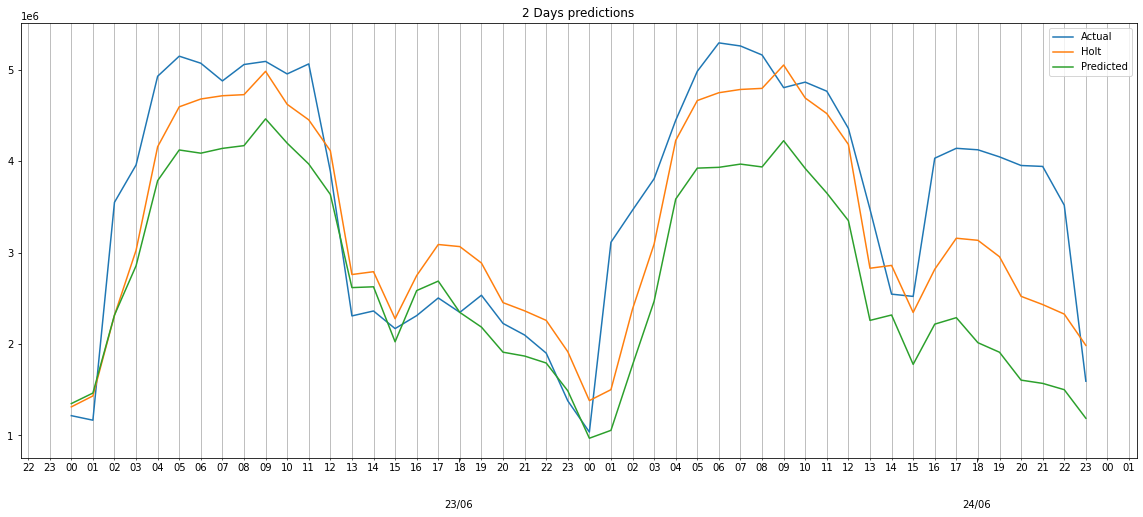

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(test[:48], label='Actual')
ax.plot(prediction_h[:48], label='Holt')
ax.plot(pred.predicted_mean[:48], label='Predicted')
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
rule = dates.rrulewrapper(dates.DAILY)
loc = dates.RRuleLocator(rule)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%d/%m'))
ax.xaxis.grid(True, which='minor')
ax.set_title('2 Days predictions')
plt.legend()

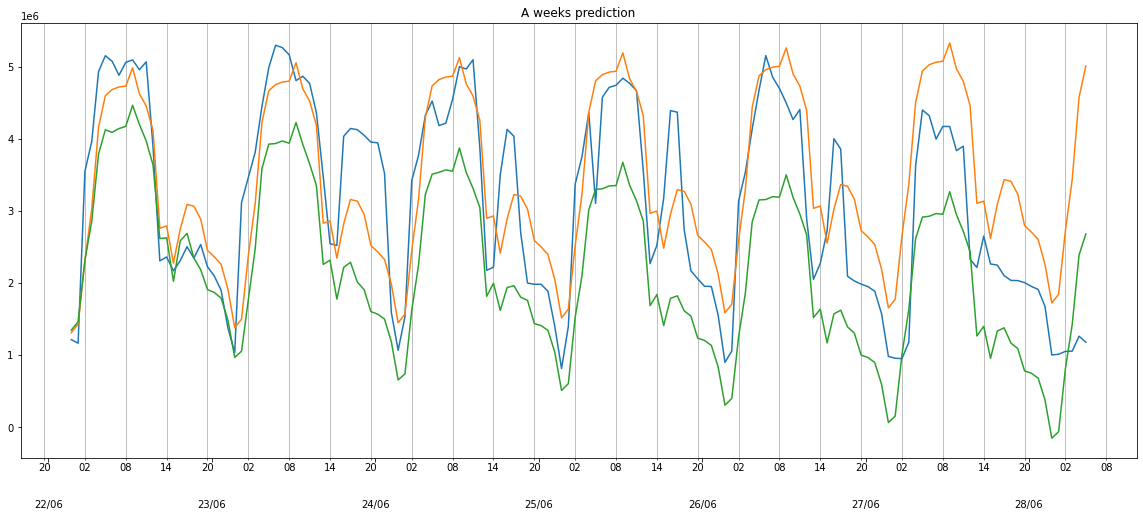

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(test[:150])
ax.plot(prediction_h, label='Holt')
ax.plot(pred.predicted_mean[:150])
ax.xaxis.set_minor_locator(dates.HourLocator(interval=6))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
rule = dates.rrulewrapper(dates.DAILY)
loc = dates.RRuleLocator(rule)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%d/%m'))
ax.set_title('A weeks prediction')
ax.xaxis.grid(True, which='minor')

# Metrics

In [ ]:
def u1(f,y):
    y = y.reset_index(drop=True).values.flatten()
    f = f.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i':f, 'y_i': y})
    df['(f_i - y_i)^2'] = np.square(df['f_i'] - df['y_i'])
    df['y_i^2'] = np.square(df['y_i'])
    df['f_i^2'] = np.square(df['f_i'])
    return (np.sqrt(np.mean(df['(f_i - y_i)^2'])))/(np.sqrt(np.mean(df['y_i^2']))+np.sqrt(np.mean(df['f_i^2'])))

def u2(f,y):
    y = y.reset_index(drop=True).values.flatten()
    f = f.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i+1':f, 'y_i+1': y})
    df['y_i'] = df['y_i+1'].shift(periods=1)
    df['numerator'] = np.square((df['f_i+1'] - df['y_i+1']) / df['y_i'])
    df['denominator'] = np.square((df['y_i+1'] - df['y_i']) / df['y_i'])
    df.dropna(inplace=True)
    return np.sqrt(np.sum(df['numerator'])/np.sum(df['denominator']))


def mape(f, y):
    f = f.reset_index(drop=True).values.flatten()
    y = y.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i':f, 'y_i': y})
    df['e'] = df['y_i'] - df['f_i']
    df['ape'] = 100*np.abs(df['e']/df['y_i'])
    return np.mean(df['ape'])

def rmse(f, y):
    f = f.reset_index(drop=True).values.flatten()
    y = y.reset_index(drop=True).values.flatten()
    df = pd.DataFrame({'f_i':f, 'y_i': y})
    df['e'] = np.square(df['y_i'] - df['f_i'])
    return np.sqrt(np.mean(df['e']))
  

    

In [ ]:
metrics = pd.DataFrame()
st = 0
for i in range(1,8):
  en = i*24
  U1= u1(prediction[st:en], test[st:en])
  U2 = u2(prediction[st:en], test[st:en])
  MAPE = mape(prediction[st:en], test[st:en])
  RMSE = rmse(prediction[st:en], test[st:en])
  metrics = metrics.append({'Day':i, 'U1':U1, 'U2':U2, 'RMSE':RMSE, 'MAPE':MAPE}, ignore_index=True)
  # st = en



In [ ]:
metrics = metrics.set_index(metrics['Day'], drop=True)
metrics = metrics.drop(columns=['Day'])

In [ ]:
metrics

,MAPE,RMSE,U1,U2
Day,,,,
1.0,14.702469533490865,656213.7281793127,0.09960929312799278,0.6039953861993997
2.0,24.40989933170928,1144421.0131843232,0.17059391422573877,0.9661934399012971
3.0,26.429894238010114,1149648.3663478876,0.17744584643471253,1.042479028966197
4.0,29.026062797008052,1193193.5401512561,0.18896096249129424,1.102517536221362
5.0,31.5905409863134,1224488.2492354033,0.19866719503702865,1.1444013342130928
6.0,33.44681612081094,1195029.7607140562,0.20075625443671827,1.131227151000867
7.0,39.18627145209811,1199662.7029289184,0.2115405413114619,1.349201347849478


No handles with labels found to put in legend.


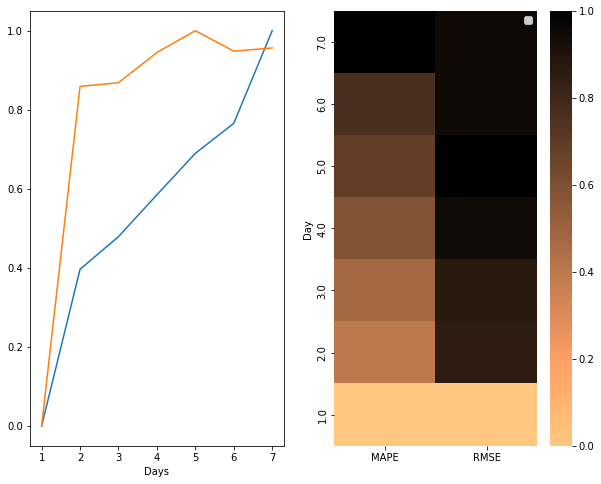

In [ ]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler()
fig, ax = plt.subplots(1, 2, figsize=(10,8))
plot_df = metrics.copy()
plot_df[['MAPE','RMSE']] = s.fit_transform(plot_df[['MAPE','RMSE']])
plot_df = plot_df.sort_index(ascending=False)
sns.heatmap(plot_df[['MAPE','RMSE']], cmap='copper_r', ax=ax[1])
ax[0].plot(plot_df['MAPE'], label='MAPE')
ax[0].plot(plot_df['RMSE'], label='RMSE')
ax[0].set_xlabel('Days')
plt.legend()

